In [115]:
import mmml
import matplotlib.pyplot as plt
import patchworklib as pw
import os
from pathlib import Path
import numpy as np
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

# Import DCMNET components
from mmml.dcmnet.dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params

from mmml.dcmnet.dcmnet.models import models, model_params
from mmml.dcmnet.dcmnet.loss import esp_mono_loss
from mmml.dcmnet.dcmnet.electrostatics import calc_esp
from mmml.dcmnet.dcmnet.utils import apply_model

import numpy as np
import jax
import jax.numpy as jnp
import sys
import os


from mmml.dcmnet.dcmnet_mcts import optimize_dcmnet_combination, DCMNETSelectionEnv

# make bwr the default colormap
plt.set_cmap('bwr')


[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


<Figure size 640x480 with 0 Axes>

In [413]:
def rotate(XYZ, rot):
    # rotate XYZ by rot degrees around the y-axis
    return np.dot(XYZ, np.array([[np.cos(rot), 0, np.sin(rot)],
                                 [0, 1, 0],
                                 [-np.sin(rot), 0, np.cos(rot)]]))

def  plot_esp_in_3d(output, rot=False, KEY="esp_target"):
    # 3d plot of ESP    
    ax = plt.axes(projection='3d')

    # remove far away points
    mask = np.linalg.norm(output['initial_vdw_surface'], axis=-1) < 10

    if rot and type(rot) == float:
        XYZ = rotate(output['initial_vdw_surface'], rot)
    else:
        XYZ = output['initial_vdw_surface']

    s = ax.scatter(*XYZ[mask].T, 
    c=output[KEY][mask].flatten(), s=15, vmin=-0.1, vmax=0.1,    )


    MIN_CO = np.min(XYZ[mask])
    MAX_CO = np.max(XYZ[mask])

    # even xyz ranges
    ax.set_xlim(MIN_CO, MAX_CO)
    ax.set_ylim(MIN_CO, MAX_CO)
    ax.set_zlim(MIN_CO, MAX_CO)
    plt.colorbar(s)
    return ax






In [414]:
output = np.load("/home/ericb/mmml/scripts/mcts/mdcmtest4/error.npy", allow_pickle=True)
output = output.tolist()
output.keys()

dict_keys(['loss', 'esp_target', 'esp_pred', 'residuals', 'selected_indices', 'charge_mapping', 'atom_index_map', 'charge_values', 'charge_positions', 'initial_esp_target', 'initial_vdw_surface'])

In [415]:
output['loss']

3.737311772056273e-06

In [416]:
output['residuals'].mean()

-0.0005455861

In [417]:
abs(output['residuals']).mean() * 627.5095, abs(output['residuals']).mean() 
# plt.hist(output['residuals'])

(5.321862246000208, 0.008480927)

In [418]:
rmse = np.sqrt(np.mean(output['residuals']**2))
rmse * 627.5095, rmse


(6.926802698873915, 0.011038562)

In [419]:
output['esp_target'] - output['esp_pred'], output['esp_target'].shape

(array([-0.00577829,  0.00575071, -0.00867098, ...,  0.02452964,
         0.00102208, -0.00306751], dtype=float32),
 (4000,))

<Axes: title={'center': 'ESP Prediction vs Target'}, xlabel='Target ESP', ylabel='Predicted ESP'>

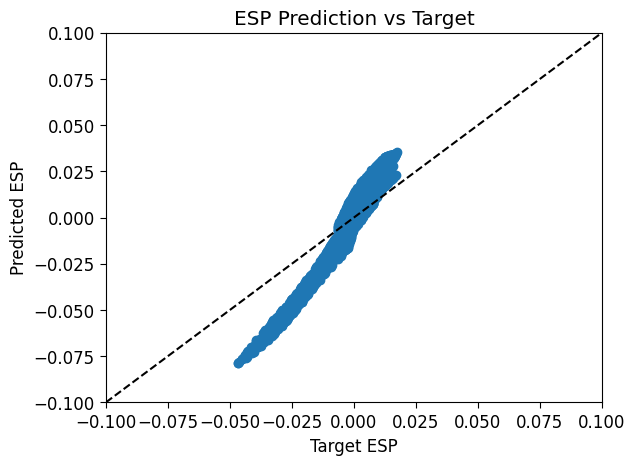

In [420]:
ax = plt.axes()
# ax.axis('equal')
MinV, MaxV = np.min(output['esp_target']), np.max(output['esp_target'])
MinV, MaxV = -0.1, 0.1
ax.scatter(output['esp_target'], output['esp_pred'])
ax.set_xlim(MinV, MaxV)
ax.set_ylim(MinV, MaxV)
ax.plot([0, 1], [0, 1], 'k--', transform=ax.transAxes)

ax.set_xlabel('Target ESP')
ax.set_ylabel('Predicted ESP')
ax.set_title('ESP Prediction vs Target')
ax



In [421]:
output['charge_values'].flatten(), output['charge_values'].flatten().sum()

(array([-0.26060402, -0.23240571, -0.0782345 , -0.10567208, -0.28683183,
        -0.59028089,  1.11056924, -0.56851035,  0.43705899, -0.47405544,
         0.1260163 , -0.18241741, -0.19467211,  0.20984836, -0.29148626,
         0.12463995, -0.20254324, -0.25695178,  0.03914341,  0.04017423,
        -0.10107837, -0.072216  ,  0.11371084,  0.11237691,  0.10588958,
         0.07754619,  0.08586583,  0.09167046,  0.09283852,  0.11267852,
         0.12823783,  0.13696991,  0.10867248,  0.14259769,  0.13850701,
         0.10608105,  0.10154855,  0.08214597,  0.07839091]),
 0.005218721926212311)

In [422]:
output["esp_pred"].max(), output["esp_target"].max()

(0.035242155, 0.017286716)

In [423]:
output["esp_pred"].min(), output["esp_target"].min()

(-0.07864779, -0.046729054)

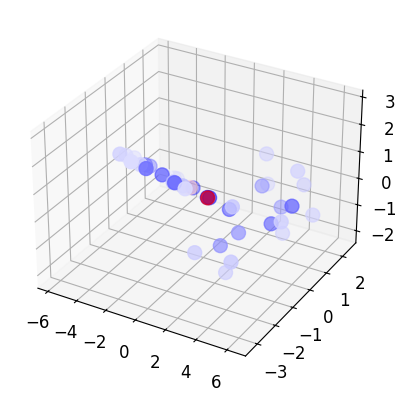

In [424]:
# 3d plot of charges 

ax = plt.axes(projection='3d')
ax.scatter(*output['charge_positions'].T, c=output['charge_values'].flatten(), s=100)
plt.show()


<Axes3D: >

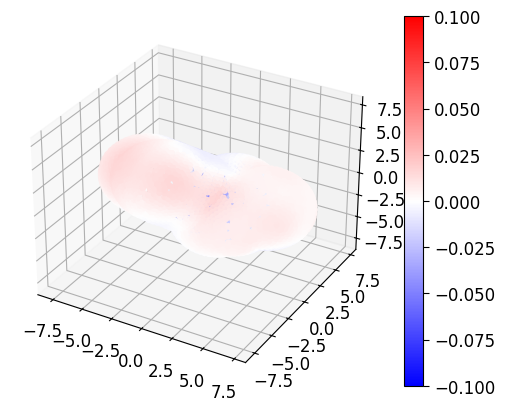

In [425]:
plot_esp_in_3d(output, rot=0.)


<Axes3D: >

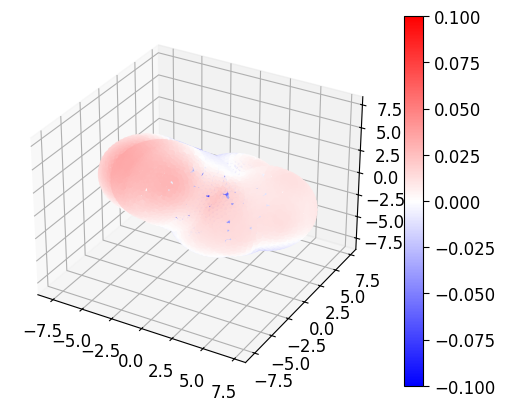

In [426]:
plot_esp_in_3d(output, rot=0., KEY="esp_pred")

<Axes3D: >

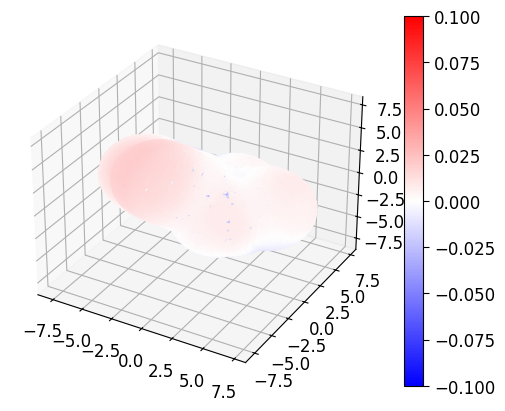

In [427]:
plot_esp_in_3d(output, rot=0., KEY="residuals")

(array([118., 119., 154., 246., 400., 573., 937., 874., 290., 289.]),
 array([-0.03237029, -0.02712365, -0.02187701, -0.01663037, -0.01138373,
        -0.00613709, -0.00089045,  0.00435619,  0.00960283,  0.01484947,
         0.02009611]),
 <BarContainer object of 10 artists>)

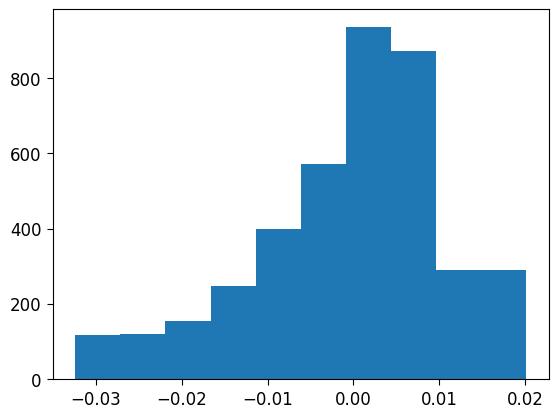

In [428]:
plt.hist(output['residuals'])

In [322]:
from mmml import dcmnet

In [21]:
import jax

from mmml.dcmnet.dcmnet.data import prepare_datasets
from mmml.dcmnet.dcmnet.modules import MessagePassingModel
from mmml.dcmnet.dcmnet.training import train_model, train_model_dipo

key = jax.random.PRNGKey(0)


In [22]:
NDCM = 7
model = MessagePassingModel(
    features=32, max_degree=2, num_iterations=2,
    num_basis_functions=32, cutoff=10.0, n_dcm=NDCM,
    include_pseudotensors=False,
)

## Data

In [23]:
current_path = Path.cwd()
print(current_path)
data_path = Path("/home/ericb")
data_files = list(data_path.glob("*npz"))
for i in range(len(data_files)):
    print(i, data_files[i])

/home/ericb/mmml/notebooks/dcmnet
0 /home/ericb/esp2000.npz


PosixPath('/home/ericb/esp2000.npz')

R
(2000, 60, 3)
Z
(2000, 60)


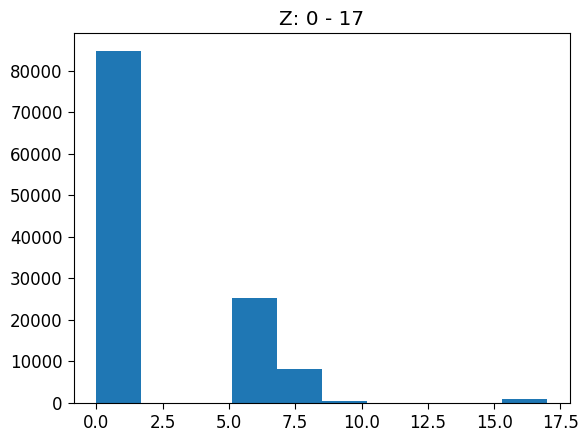

N
(2000,)


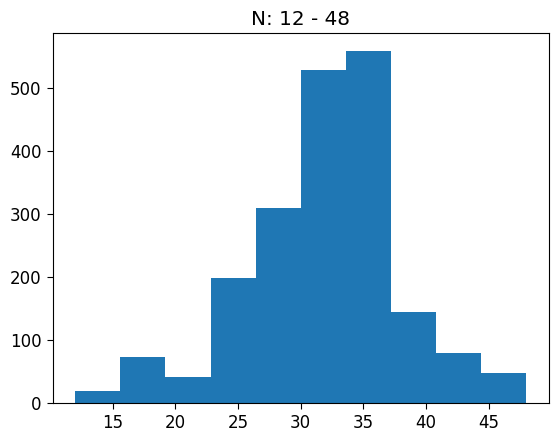

mono
(2000, 60, 1)
esp
(2000, 4953)


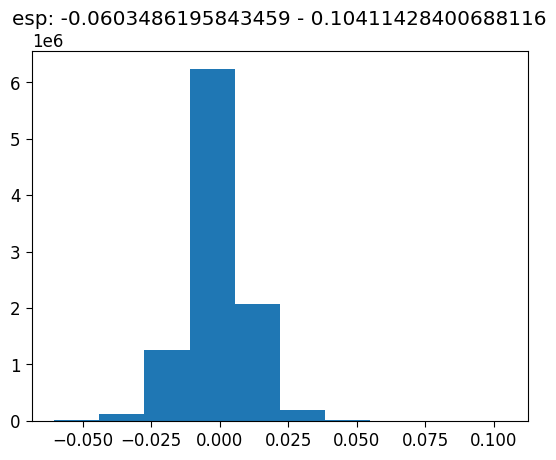

n_grid
(2000,)


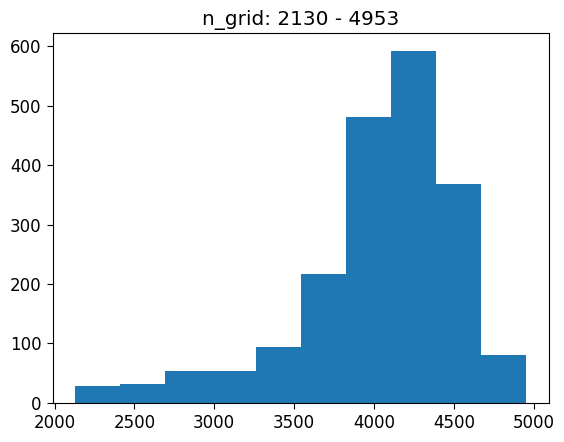

vdw_surface
(2000, 4953, 3)


In [25]:
for k in data_loaded.keys():
    print(k)
    shape = data_loaded[k].shape
    print(shape
    )
    if len(shape) < 3:
        d = data_loaded[k]
        d = d.flatten()
        plt.hist(d)
        title = f"{k}: {d.min()} - {d.max()}"
        plt.title(title)
        plt.show()

In [26]:
prepare_datasets?

Signature:
prepare_datasets(
    key,
    num_train,
    num_valid,
    filename,
    clean=False,
    esp_mask=False,
    clip_esp=False,
    natoms=60,
)
Docstring:
Prepare datasets for training and validation.

Wrapper function that calls prepare_multiple_datasets and then
creates train/validation splits and dictionaries.

Parameters
----------
key : jax.random.PRNGKey
    Random key for dataset shuffling
num_train : int
    Number of training samples
num_valid : int
    Number of validation samples
filename : str or list
    Filename(s) to load datasets from
clean : bool, optional
    Whether to filter failed calculations, by default False
esp_mask : bool, optional
    Whether to create ESP masks, by default False
clip_esp : bool, optional
    Whether to clip ESP to first 1000 points, by default False
natoms : int, optional
    Maximum number of atoms per system, by default 60

Returns
-------
tuple
    A tuple containing train_data and valid_data dictionaries
File:      ~/mmml/mmm

shape (2000, 60, 3)
R (2000, 60, 3)
(2000, 60, 3)
['R', 'Z', 'N', 'mono', 'esp', 'vdw_surface', 'n_grid', 'espMask']
2000
0 R 2000 (2000, 60, 3)
1 Z 2000 (2000, 60)
2 N 2000 (2000, 1)
3 mono 2000 (2000, 60)
4 esp 2000 (2000, 4953)
5 vdw_surface 2000 (2000, 4953, 3)
6 n_grid 2000 (2000,)
7 espMask 2000 (2000, 4953)


In [28]:
esp_data = train_data["esp"]
esp_data.shape

(1200, 4953)

## Training (1)

In [29]:
train_model?

Signature:     
train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs,
    learning_rate,
    batch_size,
    writer,
    ndcm,
    esp_w=1.0,
    restart_params=None,
    *,
    loss_step_fn: Callable = <PjitFunction of <function train_step at 0x76e364e15fc0>>,
    eval_step_fn: Callable = <PjitFunction of <function eval_step at 0x76e364b384c0>>,
    optimizer_fn: Callable = <function <lambda> at 0x76e364b39900>,
    use_ema: bool = True,
    ema_decay: float = 0.999,
    use_grad_clip: bool = False,
    grad_clip_norm: float = 2.0,
    log_extra_metrics: Optional[Callable] = <function _log_extra_metrics_none at 0x76e364b397e0>,
    save_best_params_with_ema: bool = True,
    extra_valid_args: dict = None,
    extra_train_args: dict = None,
)
Call signature: train_model(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function train_model_general at 0x76e364b39750>, loss_step_fn=<PjitFunction of <...> tra_metrics=<function _log_extr

In [30]:
# # NDCM = 7
# models = []
# paramsco = []

# for NDCM in range(1,8):

#     model = MessagePassingModel(
#         features=64, max_degree=2, num_iterations=2,
#         num_basis_functions=32, cutoff=10.0, n_dcm=NDCM,
#         include_pseudotensors=False,
#     )
#     new_params = None
    
#     params, valid_loss = train_model(
#         key=key, model=model,
#         writer=None,
#         train_data=train_data, valid_data=valid_data,
#         num_epochs=10, learning_rate=1e-3, batch_size=1,
#         ndcm=model.n_dcm, esp_w=10000.0,
#     )
#     new_params, valid_loss = train_model(
#         key=key, model=model,
#         writer=None,
#         train_data=train_data, valid_data=valid_data,
#         num_epochs=10, learning_rate=5e-4, batch_size=1,
#         ndcm=model.n_dcm, esp_w=1000.0,
#         restart_params=params if new_params is None else new_params,
#     )
#     new_params, valid_loss = train_model(
#         key=key, model=model,
#         writer=None,
#         train_data=train_data, valid_data=valid_data,
#         num_epochs=20, learning_rate=1e-4, batch_size=1,
#         ndcm=model.n_dcm, esp_w=1000.0,
#         restart_params=params if new_params is None else new_params,
#     )
#     np.save(f"modelA{NDCM}", new_params)
#     models.append(model)
#     paramsco.append(new_params)


In [31]:
def fig(output, batch):
    """ plot results of dcmnet_analysis """
    import patchworklib as pw
    VMAX = 0.01
    xy_ax = pw.Brick()
    xy_ax.scatter(batch["esp"], output['esp_pred'], s=1)
    max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
    xy_ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
    xy_ax.set_aspect('equal')

    ax_true = pw.Brick()
    Npoints = 4150
    vdw_surface_min = np.min(batch["vdw_surface"][0], axis=0)
    vdw_surface_max = np.max(batch["vdw_surface"][0], axis=0)

    ax_true.scatter(
        batch["vdw_surface"][0][:Npoints,0], 
    batch["vdw_surface"][0][:Npoints,1], 
    c=batch["esp"][0][:Npoints],
    s=0.01,
        vmin=-VMAX, vmax=VMAX
    )
    max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
    # ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
    ax_true.set_aspect('equal')

    ax_pred = pw.Brick()

    ax_pred.scatter(
        batch["vdw_surface"][0][:Npoints,0], 
    batch["vdw_surface"][0][:Npoints,1], 
    c=output['esp_pred'][:Npoints],
    s=0.01,
        vmin=-VMAX, vmax=VMAX
    )
    max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
    # ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
    ax_pred.set_aspect('equal')


    ax_diff = pw.Brick()
    ax_diff.scatter(
        batch["vdw_surface"][0][:Npoints,0], 
    batch["vdw_surface"][0][:Npoints,1], 
    c=batch["esp"][0][:Npoints] - output['esp_pred'][:Npoints],
    s=0.01,
        vmin=-VMAX, vmax=VMAX
    )
    ax_diff.set_aspect('equal')

    for _ in [ax_pred, ax_true, ax_diff]:
        _.set_xlim(vdw_surface_min[0], -vdw_surface_min[0])
        _.set_ylim(vdw_surface_min[1], -vdw_surface_min[0])

    charge_ax = pw.Brick()
    charge_ax.matshow(output["mono"][0][:int(batch["N"])],vmin=-1,vmax=1)
    scharge_ax = pw.Brick()
    scharge_ax.matshow(output["mono"][0][:int(batch["N"])].sum(axis=-1)[:, None],vmin=-1,vmax=1)
    # scharge_ax.add_colorbar(vmin=-1,vmax=1)
    scharge_ax.axis("off")
    f = xy_ax | ((ax_pred | ax_true | ax_diff) /  (scharge_ax | charge_ax))
    f.add_colorbar(vmin=-1,vmax=1)
    return f



Signature: prepare_batch(path: pathlib.Path, index=0, data=None)
Docstring:
Prepare a single batch from data for analysis.

Parameters
----------
path : Path
    Path to the data file
index : int, optional
    Index of the data to prepare
data : dict, optional
    Data dictionary to use instead of loading from file
    
Returns
-------
dict
    Batch dictionary ready for model input
File:      ~/mmml/mmml/dcmnet/dcmnet/analysis.py
Type:      function

In [33]:
valid_data.keys()

dict_keys(['R', 'Z', 'N', 'mono', 'esp', 'vdw_surface', 'n_grid', 'espMask'])

dict_keys(['R', 'Z', 'N', 'mono', 'esp', 'n_grid', 'vdw_surface'])
(1, 60)


dict_keys(['R', 'Z', 'N', 'mono', 'esp', 'n_grid', 'vdw_surface', 'dst_idx', 'src_idx', 'batch_segments', 'com', 'Dxyz'])

In [36]:
# mono, dipo = apply_model(DCM2, dcm2_params, batch, 1)
# mono.shape, dipo.shape 

In [37]:
# output = dcmnet_analysis(new_params, model, batch)
# print(output["rmse_model_masked"]), print(output["rmse_model"]);

In [38]:
def get_3d_views(output, batch):
    R = output["dipo"][:int(batch["N"])*NDCM]
    Z = np.array([1 if _ > 0 else 1 for _ in output["mono"][0][:int(batch["N"])].flatten()])
    R.shape, Z.shape
    dcm_atoms = ase.Atoms(Z, R)
    view(dcm_atoms,  viewer="x3d",
    viewer_kwargs={"width": 1000, "height": 1000, "show_unit_cell": 1})
    import ase
    from ase.visualize import view
    atoms = ase.Atoms(batch["Z"][:int(batch["N"])], 
    batch["R"][:int(batch["N"])])
    view(atoms, viewer="x3d")

In [40]:
# model_charges

In [42]:
batch


{'R': array([[ 5.58051564,  0.23289102,  0.24175247],
        [ 4.38706733,  0.12979814, -0.53103039],
        [ 3.59514447, -1.02791267, -0.28177938],
        [ 2.29770986, -0.938263  , -1.02121798],
        [ 1.54141993,  0.18009713, -0.48666651],
        [ 0.14238418,  0.11194611, -0.23606383],
        [-0.7326492 ,  0.9312906 , -0.85773054],
        [-2.06109319,  0.90012967, -0.65184392],
        [-2.89964375,  1.75016388, -1.30609954],
        [-4.22793466,  1.73944394, -1.11868858],
        [-4.75531053,  0.82937667, -0.22751461],
        [-3.92233872, -0.04618914,  0.45051282],
        [-2.55306624, -0.0218004 ,  0.24528654],
        [-1.70488107, -0.85545274,  0.88349429],
        [-1.93894547, -1.81851751,  1.78383203],
        [-0.7410933 , -2.4112033 ,  2.1584339 ],
        [ 0.25061103, -1.76345467,  1.44127829],
        [-0.37200609, -0.80976997,  0.66392772],
        [ 2.29598716,  1.39234359, -0.21548652],
        [ 3.68299197,  1.33753154, -0.75183475],
        [ 5.439

In [43]:
print("1. Molecular System:")
print(f"   - {len(molecular_data['Z'])} atoms")
print(f"   - Atomic numbers: {molecular_data['Z']}")
print(f"   - Atom positions:")
for i, pos in enumerate(molecular_data['R']):
    print(f"     Atom {i}: {pos}")

print("\n2. Available Models and Charges:")
total_charges = 0
for model_id, charges in model_charges.items():
    n_charges = charges.shape[1]
    total_charges += n_charges
    print(f"   - DCM{model_id+1}: {n_charges} charges per atom")
    print(f"     Example charges for atom 0: {charges[0].tolist()}")
    print(f"     Example positions for atom 0:")
    for j, pos in enumerate(model_positions[model_id][0]):
        print(f"       Charge {j}: {pos}")

print(f"\n   Total charges per atom across all models: {total_charges}")
print(f"   Total possible charge combinations: {total_charges ** len(molecular_data['Z'])}")

print("\n3. Creating DCMNET Selection Environment...")
env = DCMNETSelectionEnv(molecular_data, esp_target, vdw_surface, model_charges, model_positions)

print(f"   - Environment state shape: {env.selected_charges.shape}")
print(f"   - Charge mapping: {env.charge_mapping}")
print(f"   - Legal actions: {len(env.legal_actions())} possible (atom_idx, charge_idx) pairs")

print("\n4. Running MCTS Optimization...")
best_selection, best_loss = optimize_dcmnet_combination(
    molecular_data=molecular_data,
    esp_target=esp_target,
    vdw_surface=vdw_surface,
    model_charges=model_charges,
    model_positions=model_positions,
    n_simulations=100,  # Small number for demo
    temperature=1.0
)

1. Molecular System:
   - 60 atoms
   - Atomic numbers: [6 7 6 6 7 6 7 6 7 6 6 6 6 7 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   - Atom positions:
     Atom 0: [5.58051564 0.23289102 0.24175247]
     Atom 1: [ 4.38706733  0.12979814 -0.53103039]
     Atom 2: [ 3.59514447 -1.02791267 -0.28177938]
     Atom 3: [ 2.29770986 -0.938263   -1.02121798]
     Atom 4: [ 1.54141993  0.18009713 -0.48666651]
     Atom 5: [ 0.14238418  0.11194611 -0.23606383]
     Atom 6: [-0.7326492   0.9312906  -0.85773054]
     Atom 7: [-2.06109319  0.90012967 -0.65184392]
     Atom 8: [-2.89964375  1.75016388 -1.30609954]
     Atom 9: [-4.22793466  1.73944394 -1.11868858]
     Atom 10: [-4.75531053  0.82937667 -0.22751461]
     Atom 11: [-3.92233872 -0.04618914  0.45051282]
     Atom 12: [-2.55306624 -0.0218004   0.24528654]
     Atom 13: [-1.70488107 -0.85545274  0.88349429]
     Atom 14: [-1.93894547 -1.81851751  1.78383203]
     Atom 15: [-0.7410933 -2.4112

In [44]:
best_selection, best_loss

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int8),
 inf)